In [1]:
%matplotlib inline
%autosave 300
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)
import wave
import pyaudio
from audio2numpy import open_audio
from IPython.display import Audio
from scipy import signal
from scipy.fftpack import fft,fftshift
from scipy.io.wavfile import write
from scipy.signal import  firwin, freqz, firwin2, butter

Autosaving every 300 seconds


In [2]:
# FBCFNOMOD
# This function creates a feed-back comb filter by 
# processing an individual input sample and updating 
# a delay buffer used in a loop to index each sample
# in a signal. This implementation does not use
# fractional delay. Therefore, the delay time
# cannot be modulated.
#
# Input Variables
#   n : current sample number of the input signal
#   delay : samples of delay
#   fbGain : feed-back gain (linear scale)
#
# See also FBCF

def fbcfNoMod(inx,buffer,n,delay,fbGain):

    # Determine indexes for circular buffer
    length = len(buffer)
    indexC = np.mod(n-1,length)# Current index 
    indexD = np.mod(n-delay-1,length).astype(int) # Delay index

    out = buffer[indexD]
    buffer[indexC] = inx + fbGain*buffer[indexD]

    return out,buffer

In [3]:
# FBCF
# This function creates a feed-back comb filter by 
# processing an individual input sample and updating 
# a delay buffer used in a loop to index each sample
# in a signal. Fractional delay is implemented to make
# it possible to modulate the delay time.

# Input Variables
#   n : current sample number of the input signal
#   delay : samples of delay
#   fbGain : feed-back gain (linear scale)
#   amp : amplitude of LFO modulation
#   rate : frequency of LFO modulation

# See also FBCFNOMOD

def fbcf(inx,buffer,Fs,n,delay,fbGain,amp,rate):

    # Calculate time in seconds for the current sample
    t = (n-1)/Fs
    fracDelay = amp * np.sin(2*np.pi*rate*t);
    intDelay = np.floor(fracDelay).astype(int) 
    frac = fracDelay - intDelay 

    # Determine indexes for circular buffer
    length = len(buffer)
    indexC = np.mod(n-1,length).astype(int) # Current index 
    indexD = np.mod(n-delay-1+intDelay,length).astype(int) # Delay index
    indexF = np.mod(n-delay-1+intDelay+1,length).astype(int) # Fractional index

    out = (1-frac)*buffer[indexD] + (frac)*buffer[indexF]

    # Store the current output in appropriate index
    buffer[indexC] = inx + fbGain*out

    return out, buffer

In [4]:
# FBCFEXAMPLE
# This script uses a feed-back comb filter (FBCF)
# function, applied to an acoustic guitar recording. 

# See also FBCFNOMOD, FBCF

filename = "textbookcode-master\Ch_13\AcGtr.wav"
[inx,Fs] = open_audio(filename)

maxDelay = np.ceil(.05*Fs).astype(int) #maximum delay of 50 ms
buffer = np.zeros(maxDelay) # initialize delay buffer

d = .04*Fs # 40 ms of delay
g = -0.7   # Feed-back gain value

rate = 0.6 # Hz (frequency of LFO)
amp = 6 # Range of +,- 6 samples for delay

# Initialize Output Signal
N = len(inx)
out = np.zeros(N)

for n in range(N):
    
    # uncomment to use fbcfNoMod.m function
    #out[n],buffer = fbcfNoMod(inx[n],buffer,n,d,g)
    
    # Use fbcf.m function
    out[n],buffer = fbcf(inx[n],buffer,Fs,n,d,g,amp,rate)

In [5]:
Audio(out,rate=Fs)

### series

In [6]:
#FBCFSERIESEXAMPLE
# This script uses series feed-back comb filter (FBCF)
# functions, applied to an acoustic guitar recording. 

# See also FBCFPARALLELEXAMPLE

filename = "textbookcode-master\Ch_13\AcGtr.wav"
[inx,Fs] = open_audio(filename)

maxDelay = np.ceil(.07*Fs).astype(int) # max delay of 70 ms
buffer1 = np.zeros(maxDelay) 
buffer2 = np.zeros(maxDelay) 

d1 = np.fix(.042*Fs) # 42 ms of delay
g1 = 0.5
d2 = np.fix(.053*Fs) # 53 ms of delay
g2 = -0.5

rate1 = 0.6 # Hz (frequency of LFO)
amp1 = 6 # Range of +- 6 samples for delay
rate2 = 0.5 # Hz (frequency of LFO)
amp2 = 8 # Range of +- 8 samples for delay

# Initialize Output Signal
N = len(inx)
out = np.zeros(N)

for n in range(N):
    
    # Two Series FBCFs
    w,buffer1 = fbcf(inx[n],buffer1,Fs,n,d1,g1,amp1,rate1)
    
    # The output "w" of the first FBCF is used
    # as the input to the second FBCF
    out[n],buffer2 = fbcf(w,buffer2,Fs,n,d2,g2,amp2,rate2)    



In [7]:
Audio(out,rate=Fs)

### parallel

In [8]:
# FBCFPARALLELEXAMPLE
# This script uses parallel feed-back comb filter (FBCF)
# functions, applied to an acoustic guitar recording.

# See also FBCFSERIESEXAMPLE

filename = "textbookcode-master\Ch_13\AcGtr.wav"
[inx,Fs] = open_audio(filename)

maxDelay = np.ceil(.07*Fs).astype(int) # max delay of 70 ms
buffer1 = np.zeros(maxDelay) 
buffer2 = np.zeros(maxDelay) 

d1 = np.fix(.047*Fs) # 47 ms of delay
g1 = 0.5
d2 = np.fix(.053*Fs) # 53 ms of delay
g2 = -0.5

rate1 = 0.6 # Hz (frequency of LFO)
amp1 = 6 # Range of +- 6 samples for delay
rate2 = 0.5#% Hz (frequency of LFO)
amp2 = 8 # Range of +- 8 samples for delay

# Initialize Output Signal
N = len(inx)
out = np.zeros(N)

for n in range(N):
    
    # Two Parallel FBCFs
    w1,buffer1 = fbcf(inx[n],buffer1,Fs,n,d1,g1,amp1,rate1)
    # Both FBCFs receive "in" to create
    # parallel processing
    w2,buffer2 = fbcf(inx[n],buffer2,Fs,n,d2,g2,amp2,rate2)
    # The output of each FBCF is summed together
    # to complete parallel processing
    out[n] = w1 + w2


In [9]:
Audio(out,rate=Fs)

### apf

In [8]:
# APF
# This function creates an all-pass filter by 
# processing an individual input sample and updating 
# a delay buffer used in a loop to index each sample
# in a signal.

# Input Variables
#   n : current sample number of the input signal
#   delay : samples of delay
#   gain : feed-back gain (linear scale)
#   amp : amplitude of LFO modulation
#   rate : frequency of LFO modulation

def apf(inx,buffer,Fs,n,delay,gain,amp,rate):

    # Calculate time in seconds for the current sample
    t = (n-1)/Fs
    fracDelay = amp * np.sin(2*np.pi*rate*t)
    intDelay = np.floor(fracDelay).astype(int)
    frac = fracDelay - intDelay 

    # Determine indexes for circular buffer
    length = len(buffer)
    indexC = np.mod(n-1,length).astype(int) # Current index 
    indexD = np.mod(n-delay-1+intDelay,length).astype(int) # Delay index
    indexF = np.mod(n-delay-1+intDelay+1,length).astype(int) # Fractional index

    # Temp variable for output of delay buffer
    w = (1-frac)*buffer[indexD] + (frac)*buffer[indexF]

    # Temp variable used for the node after the input sum
    v = inx + (-gain*w)

    # Summation at output
    out = (gain * v) + w

    # Store the current input to delay buffer
    buffer[indexC] = v

    return out, buffer

In [11]:
# APFEXAMPLE
# This script uses an all-pass filter
# function, applied to an acoustic guitar recording. 

# See also APF

filename = "textbookcode-master\Ch_13\AcGtr.wav"
[inx,Fs] = open_audio(filename)

maxDelay = np.max(np.ceil(.05*Fs)).astype(int)  # maximum delay of 50 ms
buffer = np.zeros(maxDelay) 

d = np.ceil(.042*Fs) # 42 ms of delay
g = 0.9

rate = 0.9 # Hz (frequency of LFO)
amp = 6 # Range of +,- 6 samples for delay

# Initialize Output Signal
N = len(inx)
out = np.zeros(N)

for n in range(N):
    
    # Use apf.m function
    out[n],buffer = apf(inx[n],buffer,Fs,n,d,g,amp,rate)
    

In [12]:
Audio(out,rate=Fs)

### schrieder reverb

In [13]:
# SCHROEDERREVERB
# This script implements the Schroeder Reverb algorithm
# by using feed-back comb filters (fbcf) and all-passs
# filters (apf)

# See also FBCF, APF

filename = "textbookcode-master\Ch_13\AcGtr.wav"
[inx,Fs] = open_audio(filename)

# Max delay of 70 ms
maxDelay = np.ceil(.07*Fs).astype(int)  
# Initialize all buffers (there are 6 total = 4 FBCF, 2 APF)
buffer1 = np.zeros(maxDelay)
buffer2 = np.zeros(maxDelay) 
buffer3 = np.zeros(maxDelay)
buffer4 = np.zeros(maxDelay)
buffer5 = np.zeros(maxDelay)
buffer6 = np.zeros(maxDelay) 

# Delay and Gain Parameters
d1 = np.fix(.0297*Fs)
g1 = 0.75
d2 = np.fix(.0371*Fs)
g2 = -0.75
d3 = np.fix(.0411*Fs)
g3 = 0.75;
d4 = np.fix(.0437*Fs)
g4 = -0.75
d5 = np.fix(.005*Fs)
g5 = 0.7
d6 = np.fix(.0017*Fs)
g6 = 0.7

# LFO parameters
rate1 = 0.6
amp1 = 8
rate2 = 0.71
amp2 = 8
rate3 = 0.83
amp3 = 8
rate4 = 0.95
amp4 = 8
rate5 = 1.07
amp5 = 8
rate6 = 1.19
amp6 = 8

# Initialize Output Signal
N = len(inx)
out = np.zeros(N)

for n in range(N):
    
    # Four Parallel FBCFs
    w1,buffer1 = fbcf(inx[n],buffer1,Fs,n,d1,g1,amp1,rate1)
    
    w2,buffer2 = fbcf(inx[n],buffer2,Fs,n,d2,g2,amp2,rate2)
    
    w3,buffer3 = fbcf(inx[n],buffer3,Fs,n,d3,g3,amp3,rate3)
    
    w4,buffer4 = fbcf(inx[n],buffer4,Fs,n,d4,g4,amp4,rate4)
    
    # Combine parallel paths
    combPar = 0.25*(w1 + w2 + w3 + w4)
    
    # Two Series All-pass Filters
    w5,buffer5 = apf(combPar,buffer5,Fs,n,d5,g5,amp5,rate5)
    
    out[n],buffer6 = apf(w5,buffer6,Fs,n,d6,g6,amp6,rate6)

In [14]:
Audio(out,rate=Fs)

### moorer

In [12]:
# EARLYREFLECTIONS
# This function creates a tapped delay line to 
# be used for the Early Reflections of a reverb algorithm.
# The delays and gains of the taps are included in this 
# function, and were based on an IR measurement from a 
# recording studio in Nashville, TN. 

# See also MOORERREVERB

def earlyReflections(inx,buffer,Fs,n):

    # Delay times converted from milliseconds
    delayTimes = np.fix(Fs*np.array([0, 0.01277, 0.01283, 0.01293, 0.01333,
        0.01566, 0.02404, 0.02679, 0.02731, 0.02737, 0.02914,
        0.02920, 0.02981, 0.03389, 0.04518, 0.04522,
        0.04527, 0.05452, 0.06958]))

    # There must be a "gain" for each of the "delayTimes"
    gains = np.array([1, 0.1526, -0.4097, 0.2984, 0.1553, 0.1442,
        -0.3124, -0.4176, -0.9391, 0.6926, -0.5787, 0.5782,
         0.4206, 0.3958, 0.3450, -0.5361, 0.417, 0.1948, 0.1548])          

    # Determine indexes for circular buffer
    length = len(buffer)
    indexC = np.mod(n-1,length).astype(int) # Current index 
    buffer[indexC] = inx

    out = 0 # Initialize the output to be used in loop

    # Loop through all the taps
    for tap in range(len(delayTimes)):
        # Find the circular buffer index for the current tap
        indexTDL = np.mod(n-delayTimes[tap]-1,length).astype(int)  

        # "Tap" the delay line and add current tap with output
        out = out + gains[tap] * buffer[indexTDL]

    return out, buffer

### lpcf

In [13]:
# LPCF
# This function creates a feed-back comb filter 
# with a LPF in the feed-back path.

# Input Variables
#   n : current sample number of the input signal
#   delay : samples of delay
#   fbGain : feed-back gain (linear scale)
#   amp : amplitude of LFO modulation
#   rate : frequency of LFO modulation
#   fbLPF : output delayed one sample to create basic LPF

# See also MOORERREVERB

def lpcf(inx,buffer,Fs,n,delay,fbGain,amp,rate,fbLPF):

    # Calculate time in seconds for the current sample
    t = (n-1)/Fs
    fracDelay = amp * np.sin(2*np.pi*rate*t)
    intDelay = np.floor(fracDelay).astype(int) 
    frac = fracDelay - intDelay

    # Determine indexes for circular buffer
    length = len(buffer)
    indexC = np.mod(n-1,length).astype(int) # Current index 
    indexD = np.mod(n-delay-1+intDelay,length).astype(int) # Delay index
    indexF = np.mod(n-delay-1+intDelay+1,length).astype(int) # Fractional index

    out = (1-frac)*buffer[indexD] + (frac)*buffer[indexF]

    # Store the current output in appropriate index
    # The LPF is created by adding the current output
    # with the previous sample, both are weighted 0.5
    buffer[indexC] = inx + fbGain*(0.5*out + 0.5*fbLPF)

    # Store the current output for the Feed-back LPF 
    # to be used with the next sample
    fbLPF = out

    return out,buffer,fbLPF

In [14]:
# MOORERREVERB
# This script implements the Moorer Reverb algorithm
# by modifying the Schroeder Reverb script. First,
# an additional step to add Early Reflections is included.
# Second, a simple low-pass filter is included in the feed-back 
# path of the comb filters.

# See also EARLYREFLECTIONS, LPCF

filename = "textbookcode-master\Ch_13\AcGtr.wav"
[inx,Fs] = open_audio(filename)

inx = np.hstack([inx, np.zeros(Fs*3)])# Add zero-padding for reverb tail
    
# Max delay of 70 ms
maxDelay = np.ceil(.07*Fs).astype(int)  
# Initialize all buffers
buffer1 = np.zeros(maxDelay) 
buffer2 = np.zeros(maxDelay) 
buffer3 = np.zeros(maxDelay)
buffer4 = np.zeros(maxDelay) 
buffer5 = np.zeros(maxDelay)
buffer6 = np.zeros(maxDelay) 

# Early Reflections Tapped Delay Line
bufferER = np.zeros(maxDelay)

# Delay and Gain Parameters
d1 = np.fix(.0297*Fs)
g1 = 0.9
d2 = np.fix(.0371*Fs)
g2 = -0.9
d3 = np.fix(.0411*Fs)
g3 = 0.9
d4 = np.fix(.0437*Fs)
g4 = -0.9
d5 = np.fix(.005*Fs)
g5 = 0.7
d6 = np.fix(.0017*Fs)
g6 = 0.7

# LFO parameters
rate1 = 0.6
amp1 = 8 
rate2 = 0.71 
amp2 = 8
rate3 = 0.83
amp3 = 8 
rate4 = 0.95
amp4 = 8
rate5 = 1.07
amp5 = 8 
rate6 = 1.19
amp6 = 8

# Variables used as delay for a simple LPF in each Comb Filter function
fbLPF1 = 0
fbLPF2 = 0
fbLPF3 = 0
fbLPF4 = 0

# Initialize Output Signal
N = len(inx)
out = np.zeros(N)

for n in range(N):
    
    # Early Reflections TDL
    [w0 , bufferER] = earlyReflections(inx[n],bufferER,Fs,n);
    
    # Four Parallel LPCFs
    [w1,buffer1,fbLPF1] = lpcf(w0,buffer1,Fs,n,d1,g1,amp1,rate1,fbLPF1)
    
    [w2,buffer2,fbLPF2] = lpcf(w0,buffer2,Fs,n,d2,g2,amp2,rate2,fbLPF2)
    
    [w3,buffer3,fbLPF3] = lpcf(w0,buffer3,Fs,n,d3,g3,amp3,rate3,fbLPF3)
    
    [w4,buffer4,fbLPF4] = lpcf(w0,buffer4,Fs,n,d4,g4,amp4,rate4,fbLPF4)
    
    # Combine parallel paths
    combPar = 0.25*(w1 + w2 + w3 + w4)
    
    # Two Series All-pass Filters
    [w5,buffer5] = apf(combPar,buffer5,Fs,n,d5,g5,amp5,rate5)
    
    [out[n],buffer6] = apf(w5,buffer6,Fs,n,d6,g6,amp6,rate6)
    

In [15]:
Audio(out,rate=Fs)

### crossover feedback

In [22]:
# MODDELAY
# This function creates a series delay effect 
# using a buffer. The delay time can be modulated 
# based on the LFO parameters "depth" and "rate"

# Input Variables
#   in : single sample of the input signal
#   buffer : used to store delayed samples of the signal
#   n : current sample number used for the LFO
#   depth : range of modulation (samples)
#   rate : speed of modulation (frequency, Hz)

def modDelay(inx,buffer,Fs,n,delay,depth,rate):

    # Calculate time in seconds for the current sample
    t = (n-1)/Fs
    fracDelay = depth * np.sin(2*np.pi*rate*t)
    intDelay = np.floor(fracDelay).astype(int)
    frac = fracDelay - intDelay

    # Determine indexes for circular buffer
    length = len(buffer);
    indexC = np.mod(n-1,length).astype(int) # Current index 
    indexD = np.mod(n-delay-1+intDelay,length).astype(int) # Delay index
    indexF = np.mod(n-delay-1+intDelay+1,length).astype(int) # Fractional index


    out = (1-frac) * buffer[indexD] + (frac) * buffer[indexF]

    # Store the current output in appropriate index
    buffer[indexC] = inx

    return out, buffer

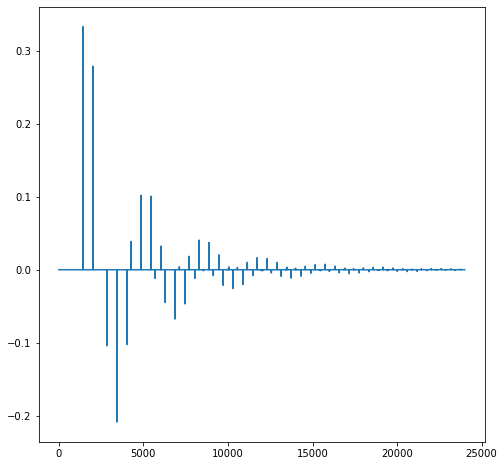

In [23]:
# CROSSOVERFEEDBACK
# This script implements two comb filters with
# crossover feedback

# See also MODDELAY

Fs = 48000
inx =np.hstack([1, np.zeros(int(Fs*0.5))])

# Max delay of 70 ms
maxDelay = np.ceil(.07*Fs).astype(int)  
# Initialize all buffers
buffer1 = np.zeros(maxDelay)
buffer2 = np.zeros(maxDelay)  

# Delay and Gain Parameters
d1 = np.fix(.0297*Fs) 
d2 = np.fix(.0419*Fs)
g11 = -0.75
g12 = -0.75
g21 = -0.75
g22 = -0.75

# LFO parameters
rate1 = 0.6
amp1 = 3 
rate2 = 0.71
amp2 = 3

# Initialize Output Signal
N = len(inx)
out = np.zeros(N)

fb1 = 0
fb2 = 0 # Feed-back holding variables

for n in range(N):
    
    # Combine input with feed-back for respective delay lines 
    inDL1 = inx[n] + fb1
    inDL2 = inx[n] + fb2
    
    # Two Parallel Delay Lines
    
    [outDL1,buffer1] = modDelay(inDL1,buffer1,Fs,n,d1,amp1,rate1)
    
    [outDL2,buffer2] = modDelay(inDL2,buffer2,Fs,n,d2,amp2,rate2)
    
    # Combine parallel paths
    out[n] = 0.5*(outDL1 + outDL2)
    
    # Calculate Feed-back (including crossover)
    fb1 = 0.5*(g11 * outDL1 + g21 * outDL2)
    fb2 = 0.5*(g12 * outDL1 + g22 * outDL2)
    

plt.plot(out)

### FDN example

In [25]:
# FDNEXAMPLE
# This script implements a feed-back delay network
# using a Stautner and Puckette matrix.

# See also MODDELAY

filename = "textbookcode-master\Ch_13\AcGtr.wav"
[inx,Fs] = open_audio(filename)

# Add extra space at end for the reverb tail
inx =np.hstack([inx, np.zeros(Fs*3)])

# Max delay of 70 ms
maxDelay = np.ceil(.07*Fs).astype(int)  
# Initialize all buffers
buffer1 = np.zeros(maxDelay)
buffer2 = np.zeros(maxDelay) 
buffer3 = np.zeros(maxDelay)
buffer4 = np.zeros(maxDelay)  

# Delay and Gain Parameters
d1 = np.fix(.0297*Fs)
d2 = np.fix(.0371*Fs)
d3 = np.fix(.0411*Fs) 
d4 = np.fix(.0437*Fs) 
g11 = 0; g12 = 1; g13 = 1; g14 = 0;  # Stautner and Puckette
g21 =-1; g22 = 0; g23 = 0; g24 =-1;  # Feed-back Matrix
g31 = 1; g32 = 0; g33 = 0; g34 =-1;
g41 = 0; g42 = 1; g43 =-1; g44 = 0;

# LFO parameters
rate1 = 0.6; amp1 = 5; 
rate2 = 0.71; amp2 = 5;
rate3 = 0.83; amp3 = 5; 
rate4 = 0.95; amp4 = 5;

# Initialize Output Signal
N = len(inx)
out = np.zeros(N)

# Feed-back holding variables
fb1 = 0; fb2 = 0; fb3 = 0; fb4 = 0;

# Gain to control reverb time
g = .67
for n in range(N):
    
    # Combine input with feed-back for respective delay lines 
    inDL1 = inx[n] + fb1
    inDL2 = inx[n] + fb2
    inDL3 = inx[n] + fb3
    inDL4 = inx[n] + fb4
    
    # Four Parallel Delay Lines
    [outDL1,buffer1] = modDelay(inDL1,buffer1,Fs,n,d1,amp1,rate1)
    
    [outDL2,buffer2] = modDelay(inDL2,buffer2,Fs,n,d2,amp2,rate2)

    [outDL3,buffer3] = modDelay(inDL3,buffer3,Fs,n,d3,amp3,rate3)
    
    [outDL4,buffer4] = modDelay(inDL4,buffer4,Fs,n,d4,amp4,rate4)
    
    # Combine parallel paths
    out[n] = 0.25*(outDL1 + outDL2 + outDL3 + outDL4)
    
    # Calculate Feed-back (including cross-over)
    fb1 = g*(g11*outDL1 + g21*outDL2 + g31*outDL3 + g41*outDL4)
    fb2 = g*(g12*outDL1 + g22*outDL2 + g32*outDL3 + g42*outDL4)
    fb3 = g*(g13*outDL1 + g23*outDL2 + g33*outDL3 + g43*outDL4)
    fb4 = g*(g14*outDL1 + g24*outDL2 + g34*outDL3 + g44*outDL4)


In [26]:
Audio(out,rate=Fs)

### reverb time

<ipython-input-32-f468be16164d>:76: RuntimeWarning: divide by zero encountered in log10
  plt.plot(t,20*np.log10(np.abs(out)))


(0.0, 4.0, -80.0, 0.0)

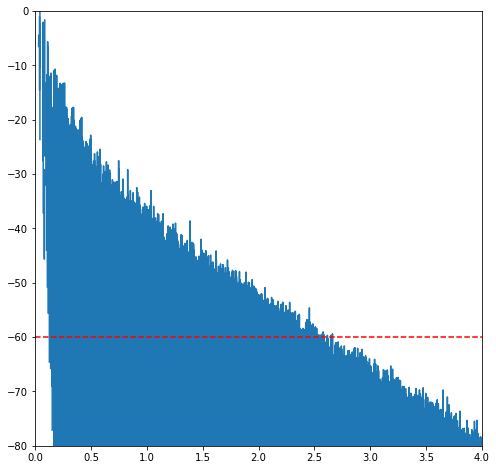

In [32]:
# RT60
# This script analyzes the RT-60
# of a feed-back delay network by visualizing
# an impulse response on the decibel scale.

Fs = 48000
Ts = 1/Fs
inx = np.hstack([1, np.zeros(Fs*5)]) # Impulse Signal

# Max delay of 70 ms
maxDelay = np.ceil(.07*Fs).astype(int)  
# Initialize all buffers
buffer1 = np.zeros(maxDelay)
buffer2 = np.zeros(maxDelay) 
buffer3 = np.zeros(maxDelay)
buffer4 = np.zeros(maxDelay)  

# Delay and Gain Parameters
d1 = np.fix(.0297*Fs) 
d2 = np.fix(.0371*Fs)
d3 = np.fix(.0411*Fs) 
d4 = np.fix(.0437*Fs)

g11 = 0; g12 = 1; g13 = 1; g14 = 0;
g21 =-1; g22 = 0; g23 = 0; g24 =-1;
g31 = 1; g32 = 0; g33 = 0; g34 =-1;
g41 = 0; g42 = 1; g43 =-1; g44 = 0;

# LFO parameters
rate1 = 0.6; amp1 = 5; 
rate2 = 0.71; amp2 = 5;
rate3 = 0.83; amp3 = 5; 
rate4 = 0.95; amp4 = 5;

# Initialize Output Signal
N = len(inx)
out = np.zeros(N)

# Feed-back holding variables
fb1 = 0; fb2 = 0; fb3 = 0; fb4 = 0;

# Gain to control reverb time
g = .67

for n in range(N):
    
    # Combine input with feed-back for respective delay lines 
    inDL1 = inx[n] + fb1
    inDL2 = inx[n] + fb2
    inDL3 = inx[n] + fb3
    inDL4 = inx[n] + fb4
    
    # Four Parallel Delay Lines
    [outDL1,buffer1] = modDelay(inDL1,buffer1,Fs,n,d1,amp1,rate1)
    
    [outDL2,buffer2] = modDelay(inDL2,buffer2,Fs,n,d2,amp2,rate2)

    [outDL3,buffer3] = modDelay(inDL3,buffer3,Fs,n,d3,amp3,rate3)
    
    [outDL4,buffer4] = modDelay(inDL4,buffer4,Fs,n,d4,amp4,rate4)
    
    # Combine parallel paths
    out[n] = 0.25*(outDL1 + outDL2 + outDL3 + outDL4)
    
    # Calculate Feed-back (including cross-over)
    fb1 = g*(g11*outDL1 + g21*outDL2 + g31*outDL3 + g41*outDL4);
    fb2 = g*(g12*outDL1 + g22*outDL2 + g32*outDL3 + g42*outDL4);
    fb3 = g*(g13*outDL1 + g23*outDL2 + g33*outDL3 + g43*outDL4);
    fb4 = g*(g14*outDL1 + g24*outDL2 + g34*outDL3 + g44*outDL4);
    

out = out/np.max(np.abs(out)) # Normalize to Unity Gain (0 dB)

t = np.arange(0,N)*Ts
#t = [0:N-1]*Ts;
plt.plot(t,20*np.log10(np.abs(out)))
plt.plot([0, 4],[-60, -60],'r--')
plt.axis([0, 4, -80, 0])